# Assignment 3 - Regression

### Step 0: Prepare the data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [ ]:
# Read CSV file from Life-Expectancy-Data

life_data=pd.read_csv('Life-Expectancy-Data.csv')
print('Number of samples: ',len(life_data))

In [ ]:
life_data.info()

In [ ]:
life_data = life_data.drop(["ID","GDP","Population"], axis="columns")

In [ ]:
train_data=life_data.sample(frac=0.6,random_state=12)
valid_and_test=life_data.drop(train_data.index)
valid_data=valid_and_test.sample(frac=0.5,random_state=62)
test_data=valid_and_test.drop(valid_data.index)

In [ ]:
life_data["Life_expectancy"].describe()

In [ ]:
train_data["Life_expectancy"].describe()

In [ ]:
valid_data["Life_expectancy"].describe()

In [ ]:
test_data["Life_expectancy"].describe()

### Step 1: Linear regression

In [ ]:
linear_reg=LinearRegression()
linear_reg.fit(train_data[['Adult_Mortality']],train_data[['Life_expectancy']])

am_w0=float(linear_reg.intercept_)
am_w1=float(linear_reg.coef_)

In [ ]:
print(("Linear model: life expectancy = {} + ({})*Adult_Mortality").format(am_w0,am_w1))

In [ ]:
train_am_sorted=train_data.sort_values('Adult_Mortality')
predicted_life=am_w0+am_w1*train_am_sorted.Adult_Mortality

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%matplotlib inline
def plot_am_model(amr,predicted_life,observed_life):
    plt.figure(figsize=(10,10))
    plt.plot(amr,observed_life,'c.')
    plt.plot(amr,predicted_life,'k-')
    plt.xlabel("Adult mortality rate")
    plt.ylabel("Life expectancy, years")
    plt.plot()

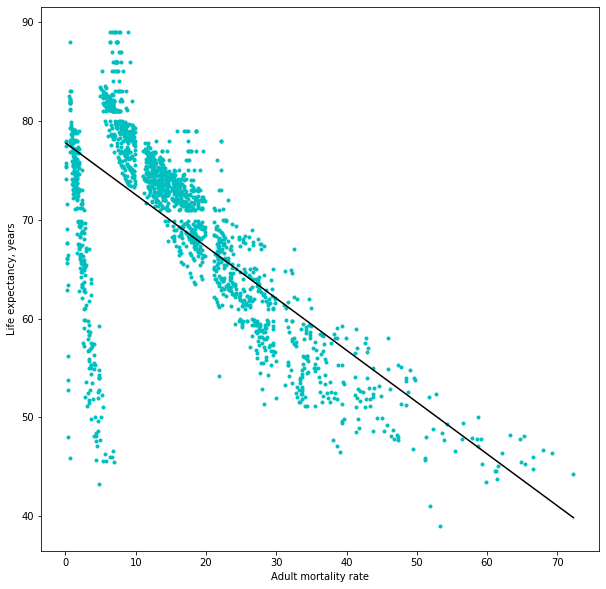

In [118]:
plot_am_model(train_am_sorted["Adult_Mortality"], predicted_life, train_am_sorted["Life_expectancy"])

### Step 2: Calculate residual sum of squares (RSS) to assess model accuracy

In [ ]:
predicted_test_life=linear_reg.predict(test_data[['Adult_Mortality']])
predicted_test_life=predicted_test_life.ravel()

**Your task:** Write a function that calculates the residual sum of squares.

In [ ]:
def rss(y,y_hat):
    tmp=y-y_hat
    tmp=tmp**2
    return tmp.sum()

In [ ]:
observed_test_life=test_data['Life_expectancy']
rss_simple=rss(observed_test_life,predicted_test_life)
print("RSS for our linear model for TEST data: %e" % rss_simple)

In [ ]:
# Calculate Mean Absolute error based on observed (sampled) and model-predicted life expectancy
# return: a floating point number
def MAE(observed_life, predicted_life):
    n=len(observed_life)
    differences=observed_life-predicted_life
    absolute_differences=np.abs(differences)
    return absolute_differences.sum()/n

mae=MAE(observed_test_life,predicted_test_life)
print("On average, our model predicts life expectancy %.1f years from the observed value" % mae)

In [ ]:
assert predicted_test_life.sum() >= 37000
assert predicted_test_life.sum() <= 42000

assert rss_simple >= 2.3e4
assert rss_simple <= 2.8e4

assert mae >= 4
assert mae <= 6

### Step 3: Compare several polynomial models, find the one with the best RSS

In [ ]:
def create_feature_matrix(input_attr_col, powers):
    df=pd.DataFrame()
    for p in powers:
        tmp=input_attr_col**p
        tag='h'+str(p)
        df[tag]=tmp
    return df

In [ ]:
a = np.array([1, 2, -5])
a1 = create_feature_matrix(a, [1])
a2 = create_feature_matrix(a, [1, 3, 5])
a3 = create_feature_matrix(a, [4, 2])

a1_exp = pd.DataFrame(data = {"h1" : a})
a2_exp = pd.DataFrame(data = {"h1" : a, "h3" : a ** 3, "h5": a ** 5})
a3_exp = pd.DataFrame(data = {"h4" : a ** 4, "h2" : a ** 2})

assert a1_exp.equals(a1)
assert a2_exp.equals(a2)
assert a3_exp.equals(a3)

In [ ]:
def predict(input_features,weights):
    return input_features.dot(weights)

In [ ]:
def poly_print(weights):
    print(np.poly1d(np.flip(weights, 0)))
    print("")

In [ ]:
best_rss=None
best_max_power=None
poly_weights=None
first=True
for max_power in range(1,20):
    train_data_matrix=create_feature_matrix(train_data.Adult_Mortality,range(0,max_power))
    valid_data_matrix=create_feature_matrix(valid_data.Adult_Mortality,range(0,max_power))
    
    model=LinearRegression(fit_intercept=False)
    model.fit(train_data_matrix,train_data['Life_expectancy'])
    pre_val=model.predict(valid_data_matrix)
    
    model_rss=rss(valid_data['Life_expectancy'],pre_val)

    if first:
        best_rss=model_rss
        best_max_power=max_power-1
        poly_weights=model.coef_
        first=False
        continue

    if model_rss < best_rss:
        best_rss=model_rss
        best_max_power=max_power-1
        poly_weights=model.coef_

In [ ]:
test_data_matrix=create_feature_matrix(test_data.Adult_Mortality,range(0,best_max_power+1))
pre_val=predict(test_data_matrix,poly_weights)
best_poly_rss=rss(test_data['Life_expectancy'],pre_val)
print("Best model found for polynomial with degree %i" %(best_max_power))
print("It has RSS for TEST data: %e" %(best_poly_rss))
print("The polynomial:")
poly_print(poly_weights)

In [ ]:
assert best_max_power == 8

assert poly_weights[0] >= 76
assert poly_weights[0] <= 77
assert poly_weights[1] >= -7
assert poly_weights[1] <= -6
assert poly_weights[2] >= 1.7
assert poly_weights[2] <= 1.8
assert poly_weights[3] >= -0.19
assert poly_weights[3] <= -0.18
assert poly_weights[4] >= 0.009
assert poly_weights[4] <= 0.01

assert best_poly_rss >= 1.8e4
assert best_poly_rss <= 1.9e4

print ("All tests passed, the calculations are correct!")

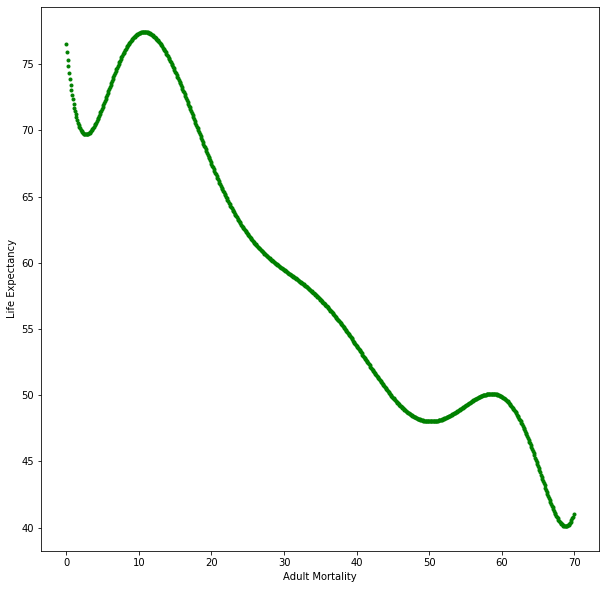

In [117]:
f_col=np.arange(0,70,step=0.1)
f_matrix=create_feature_matrix(f_col,range(0,best_max_power+1))
f_predicted=predict(f_matrix,poly_weights)

%matplotlib inline
def f_plot(x,y):
    plt.figure(figsize=(10,10))
    plt.xlabel('Adult Mortality')
    plt.ylabel('Life Expectancy')
    plt.plot(x,y,'g.')
    plt.show()

f_plot(f_col,f_predicted)

### Step 4: Use multiple regression to predict life expectancy based on several features

In [ ]:
LE_75 = life_data[(life_data["Adult_Mortality"] == 9.2) & (life_data["infant_deaths"] == 231) & (life_data["BMI"] == 28.1)]
print("Reference Life: ")
LE_75

In [ ]:
adult_infant_model=LinearRegression()
adult_infant_model.fit(train_data[['Adult_Mortality','infant_deaths']],train_data[['Life_expectancy']])

pre_val=predict(valid_data.loc[:,['Adult_Mortality','infant_deaths']],adult_infant_model.coef_.ravel())+adult_infant_model.intercept_
adult_infant_rss=rss(valid_data['Life_expectancy'],pre_val)

adult_infant_bmi_model=LinearRegression()
adult_infant_bmi_model.fit(train_data[['Adult_Mortality','infant_deaths','BMI']],train_data[['Life_expectancy']])

pre_val=predict(valid_data.loc[:,['Adult_Mortality','infant_deaths','BMI']],adult_infant_bmi_model.coef_.ravel())+adult_infant_bmi_model.intercept_
adult_infant_bmi_rss=rss(valid_data['Life_expectancy'],pre_val)

print("Model without BMI: {}\tModel with BMI: {}".format(adult_infant_rss,adult_infant_bmi_rss))

In [ ]:
china_pred_val_1=predict(LE_75.loc[:,['Adult_Mortality','infant_deaths']],adult_infant_model.coef_.ravel())+adult_infant_model.intercept_
china_pred_val_2=predict(LE_75.loc[:,['Adult_Mortality','infant_deaths','BMI']],adult_infant_bmi_model.coef_.ravel())+adult_infant_bmi_model.intercept_
print('\nChina without BMI:', china_pred_val_1.values[0])
print('China with BMI:', china_pred_val_2.values[0],'\n')

In [ ]:
pre_val = predict(test_data.loc[:,['Adult_Mortality','infant_deaths','BMI']],adult_infant_bmi_model.coef_.ravel())+adult_infant_bmi_model.intercept_
best_multi_rss=rss(test_data['Life_expectancy'],pre_val)
print("RSS for the best multi-attribute model on the TEST data: %e" %best_multi_rss)

### Step 5: Use Lasso regression to select a subset of features which are relevant for predicting life expectancy

In [ ]:
all_features = ['Year',
                'Adult_Mortality', 
                'infant_deaths',
                'Alcohol', 'percentage_expenditure', 'Hepatitis_B', 
                'Measles', 'BMI', 'under-five_deaths',
                'Polio', 'Total_expenditure',
                'Diphtheria','HIV/AIDS','thinness_1-19_years','thinness_5-9 years',
                'Income_composition_of_resources', 'Schooling']

train_data_all = train_data[all_features]

In [ ]:
lasso_model=Lasso(alpha=0.1,normalize=True,max_iter=100000)
lasso_model.fit(train_data_all,train_data['Life_expectancy'])

pre_val=predict(valid_data.loc[:,all_features],lasso_model.coef_)+lasso_model.intercept_
lasso_warmup_rss=rss(valid_data.Life_expectancy,pre_val)

**Next task:** Find which attributes have non-zero weights, print out their names and weights. Hint: create a function `print_nonzero_weights`, you will need it later.

In [ ]:
def print_nonzero_weights(df, weights):
    nonz=[]
    for ix in range(len(weights)):
        if weights[ix] != 0:
            nonz.append(ix)
    df=df.iloc[:,nonz]
    names=df.columns
    for ix in range(len(nonz)):
        print("{} --- {}".format(names[ix],weights[nonz[ix]]))

print_nonzero_weights(train_data_all,lasso_model.coef_)

In [ ]:
penalties=np.logspace(-4,3,num=30)
best_lambda=None
best_weights=None
best_intercept=None
best_rss=None
first=True
for l in penalties:
    lasso_model=Lasso(alpha=l,normalize=True,max_iter=100000)
    lasso_model.fit(train_data_all,train_data['Life_expectancy'])

    pre_val=predict(valid_data.loc[:,all_features],lasso_model.coef_)+lasso_model.intercept_
    lasso_rss=rss(valid_data.Life_expectancy,pre_val)

    if first:
        best_lambda=l
        best_weights=lasso_model.coef_
        best_intercept=lasso_model.intercept_
        best_rss=lasso_rss
        first=False
        continue
    
    if lasso_rss < best_rss:
        best_lambda=l
        best_weights=lasso_model.coef_
        best_intercept=lasso_model.intercept_
        best_rss=lasso_rss

print("Intercept: ",best_intercept)
print_nonzero_weights(train_data_all,best_weights)

In [ ]:
assert best_lambda == 0.0001

### Step 6: Additional Lasso challenge

In [ ]:
def amount_non_zero(weights):
    nonz=0
    for ix in range(len(weights)):
        if weights[ix] != 0:
            nonz+=1
    return nonz

penalties=np.logspace(-4,3,num=30)
best_lambda=None
best_weights=None
best_intercept=None
best_rss=None
first=True
for l in penalties:
    lasso_model=Lasso(alpha=l,normalize=True,max_iter=100000)
    lasso_model.fit(train_data_all,train_data['Life_expectancy'])

    if amount_non_zero(lasso_model.coef_) == 3:

        pre_val=predict(valid_data.loc[:,all_features],lasso_model.coef_)+lasso_model.intercept_
        lasso_rss=rss(valid_data.Life_expectancy,pre_val)

        if first:
            best_lambda=l
            best_weights=lasso_model.coef_
            best_intercept=lasso_model.intercept_
            best_rss=lasso_rss
            first=False
            continue

        elif lasso_rss < best_rss:
            best_lambda=l
            best_weights=lasso_model.coef_
            best_intercept=lasso_model.intercept_
            best_rss=lasso_rss

print("Intercept: {}\tLambda: {}".format(best_intercept,best_lambda))
print_nonzero_weights(train_data_all,best_weights)